## 研究分解键级

In [1]:
import sys
sys.path.append('d:/code/pywfn')
from pywfn.base import Mol
from pywfn.reader import LogReader
from pywfn.atomprop import direction
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from pywfn.bondprop import order
from pywfn.maths import CM2PM
from pywfn.maths.mol import projCM

动态链接库目录 d:\code\pywfn\pywfn\libs
当前系统:windows


In [34]:
def gtf(grid,l,m,n)->np.ndarray:
    x=grid[:,0]
    y=grid[:,1]
    z=grid[:,2]
    r2=x**2+y**2+z**2
    alp=2.0
    facs=[1,1,3]
    fac=facs[l]*facs[m]*facs[n]
    ang=l+m+n
    Nm=(2*alp/np.pi)**(3/4)*np.sqrt((4*alp)**ang/fac)
    val=x**l * y**m * z**n * np.exp(-alp*r2)*Nm
    return val


def decomOrbitals(T:np.ndarray,coefs:np.ndarray,keeps:list):
    match len(coefs):
        case 1:
            return decomOrbitalS(T,coefs,keeps)
        case 3:
            return decomOrbitalP(T,coefs,keeps)
        case 6:
            return decomOrbitalD(T,coefs,keeps)
        case _:
            return coefs

def decomOrbitalS(T:np.ndarray,coefs:np.ndarray,keeps:list[int]):
    if keeps:
        return coefs
    else:
        return np.array([0.])

# 分解P轨道
def decomOrbitalP(T:np.ndarray,rcoefs:np.ndarray,keeps:list[int])->np.ndarray:
    """分解P轨道

    Args:
        T (np.ndarray): 基坐标，每一行代表一个方向
        rcoefs (np.ndarray): 原始函数空间的基函数系数
        keeps (list[int]): 保留的角动量

    Returns:
        np.ndarray: 分解之后的轨道系数
    """
    npos=3
    cords=np.random.rand(npos,3) #随机生成3个点[n,3],[3,3]
    wfn_1=np.zeros(shape=(npos,3)) #再这些点上的波函数数值
    wfn_1[:,0]=gtf(cords,1,0,0)
    wfn_1[:,1]=gtf(cords,0,1,0)
    wfn_1[:,2]=gtf(cords,0,0,1)

    wfn_2=np.zeros(shape=(npos,3))
    wfn_2[:,0]=gtf(cords@T,1,0,0)
    wfn_2[:,1]=gtf(cords@T,0,1,0)
    wfn_2[:,2]=gtf(cords@T,0,0,1)

    Mr=np.linalg.inv(wfn_2)@wfn_1
    Mi=np.linalg.inv(Mr)
    tcoefs=Mr@rcoefs # 根据函数空间基组1下的系数获取函数空间基组2下的系数
    for i in range(3):
        if i in keeps:continue
        tcoefs[i]=0.0
    fcoefs=Mi@tcoefs # 根据修改后的函数空间基组2下的系数得到函数空间基组1下的系数
    return fcoefs

# 分解D轨道
def decomOrbitalD(T:np.ndarray,rcoefs:np.ndarray,keeps:list[int]):
    npos=6
    cords=np.random.rand(npos,3) #随机生成6个点
    wfn_1=np.zeros(shape=(npos,6))
    wfn_1[:,0]=gtf(cords,2,0,0)
    wfn_1[:,1]=gtf(cords,0,2,0)
    wfn_1[:,2]=gtf(cords,0,0,2)
    wfn_1[:,3]=gtf(cords,1,1,0)
    wfn_1[:,4]=gtf(cords,1,0,1)
    wfn_1[:,5]=gtf(cords,0,1,1)

    wfn_2=np.zeros(shape=(npos,6))
    wfn_2[:,0]=gtf(cords@T,2,0,0)
    wfn_2[:,1]=gtf(cords@T,0,2,0)
    wfn_2[:,2]=gtf(cords@T,0,0,2)
    wfn_2[:,3]=gtf(cords@T,1,1,0)
    wfn_2[:,4]=gtf(cords@T,1,0,1)
    wfn_2[:,5]=gtf(cords@T,0,1,1)

    Mr=np.linalg.inv(wfn_2)@wfn_1
    Mi=np.linalg.inv(Mr)
    tcoefs=Mr@rcoefs
    for i in range(6):
        if i in keeps:continue
        tcoefs[i]=0.0
    fcoefs=Mi@tcoefs
    return fcoefs

In [18]:
path=rf"D:\gfile\pywfn\C2_t.out"
mol=Mol(LogReader(path))
mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
mol.atom(3)._props['normal']=np.array([1,0,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,3)
sys2=dirCaler.coordSystem(3,1)

[0, 1, 2, 3, 4, 5, 6]

In [43]:
path=rf"D:\gfile\pywfn\C2.out"
mol=Mol(LogReader(path))
mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
mol.atom(3)._props['normal']=np.array([1,0,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,3)
sys2=dirCaler.coordSystem(3,1)
sys2=sys1
rcoefs=np.array([1.,2.,3.,4.,5.,6.])
decomOrbitals(sys1,rcoefs,[0])

array([-0.,  0.,  3.,  0.,  0., -0.])

In [48]:
path=rf"D:\gfile\pywfn\O2.out"
mol=Mol(LogReader(path))
mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
mol.atom(2)._props['normal']=np.array([1,0,0],dtype=float)
dirCaler=direction.Calculator(mol) # 方向计算器
sys1=dirCaler.coordSystem(1,2)
sys2=dirCaler.coordSystem(2,1)
atms=[1,2]

In [50]:
Ts=[sys1,sys2]
sig_keeps={
    0:[0], #s
    1:[0], #px,py,pz
    2:[0]  #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引

piz_keeps={
    0:[], 
    1:[2], 
    2:[2,5]  #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引

piy_keeps={
    0:[], 
    1:[1], 
    2:[1,4]  #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引
det_keeps={
    0:[], #s
    1:[], #px,py,pz
    2:[5] #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引
nmat=mol.CM.shape[0]
keepList=[sig_keeps,piz_keeps,piy_keeps,det_keeps]
orderCaler=order.Calculator(mol)

for k,keeps in enumerate(keepList):
    # if k!=1:continue
    CMt=np.zeros_like(mol.CM)
    for o in mol.O_obts: # 对每一个分子轨道进行修改
        coefDict=defaultdict(list) #系数字典
        for i in range(nmat): # 循环每一个系数
            iatm=mol.obtAtms[i]
            ishl=mol.obtShls[i]
            iang=mol.obtAngs[i]
            key=(iatm,ishl,iang)
            if iatm in atms:
                coefDict[key].append(mol.CM[i,o])
            else:
                coefDict[key].append(0)

        for key,val in coefDict.items():
            iatm,ishl,iang=key
            rcoefs=np.array(val)
            if iatm in atms:
                tcoefs=decomOrbitals(Ts[atms.index(iatm)],rcoefs,keeps[iang])
            else:
                tcoefs=np.zeros_like(rcoefs)
            # print(k,rcoefs,'->',tcoefs,keeps[iang])
            assert len(rcoefs)==len(tcoefs),"长度对不上"
            
            coefDict[key]=tcoefs.tolist()
        values=list(coefDict.values())
        CMt[:,o]=np.concatenate(values)
    # for i,line in enumerate(CMt):
    #     print(f'{mol.obtSyms[i]:<4}'+','.join([f'{e:>8.4f}' for e in line]))
    PMt=CM2PM(CMt,mol.O_obts,mol.oE) # 变换的密度矩阵
    results=orderCaler.mayer(PMt)
    print(results)
    values=results[:,-1]
    values[values<0]=0
    results[:,-1]=values**0.5
    
    print(results)
    print(f'{k:-^50}')

[[1.     2.     0.8623]]
[[1.     2.     0.9286]]
------------------------0-------------------------
[[ 1.      2.     -0.0686]]
[[1. 2. 0.]]
------------------------1-------------------------
[[1.     2.     0.9506]]
[[1.    2.    0.975]]
------------------------2-------------------------
[[1. 2. 0.]]
[[1. 2. 0.]]
------------------------3-------------------------


In [ ]:
paras=[
    {"path":"D:\gfile\pywfn\C6H6.log","atms":[1,2]},
    {"path":"D:\gfile\pywfn\CH2=CH2_wfn.out","atms":[1,4]},
    {"path":"D:\gfile\pywfn\Cu=C=C=CH2.out","atms":[1,6]},
    {"path":rf"D:\gfile\pywfn\N2.out","atms":[1,2]},
    {"path":rf"D:\gfile\pywfn\O2.out","atms":[1,2]} 
]
index=4
para=paras[index]
mol=Mol(LogReader(para["path"]))
if index==3 or index==4:
    mol.atom(1)._props['normal']=np.array([1,0,0],dtype=float)
    mol.atom(2)._props['normal']=np.array([1,0,0],dtype=float)
if index==2:
    for atm in [2,1,6]:
        mol.atom(atm)._props['normal']=np.array([0,1,0],dtype=float)

dirCaler=direction.Calculator(mol) # 方向计算器
orderCaler=order.Calculator(mol) # 键级计算器
# 计算出两个坐标系
atms:list[int]=para['atms']
atm1,atm2=atms
T1=dirCaler.coordSystem(atm1,atm2) # 两个原子的局部坐标系
T2=dirCaler.coordSystem(atm2,atm1)
T2=T1
# T2[:,1]*=-1
Ts=(T1.T,T2.T)

CMt=np.zeros_like(mol.CM) # 变换矩阵初始化
nmat=CMt.shape[0]


sig_keeps={
    0:[0], #s
    1:[1], #px,py,pz
    2:[1]  #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引

piz_keeps={
    0:[], 
    1:[2], 
    2:[2,5]  #xx,yy,zz,xy,xz,yz
    # 2:[]  #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引

pix_keeps={
    0:[], 
    1:[0], 
    2:[0,3]  #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引
det_keeps={
    0:[], #s
    1:[], #px,py,pz
    2:[4] #xx,yy,zz,xy,xz,yz
} # 每个角动量保持的索引
keepList=[sig_keeps,piz_keeps,pix_keeps,det_keeps]
nameList=['sigma','pi_z','pi_x','delta']
# keeps=pi_skeeps
for k,keeps in enumerate(keepList):
    # if k!=1:continue
    for o in mol.O_obts:
        coefDict=defaultdict(list) #系数字典
        for i in range(nmat):
            iatm=mol.obtAtms[i]
            ishl=mol.obtShls[i]
            iang=mol.obtAngs[i]
            key=(iatm,ishl,iang)
            if iatm in atms:
                coefDict[key].append(mol.CM[i,o])
            else:
                coefDict[key].append(mol.CM[i,o])
                # coefDict[key].append(0)

        for key,val in coefDict.items():
            iatm,ishl,iang=key
            rcoefs=np.array(val)
            if iatm in atms:
                tcoefs=decomOrbitals(Ts[atms.index(iatm)],rcoefs,keeps[iang])
            else:
                tcoefs=rcoefs
            assert len(rcoefs)==len(tcoefs),"长度对不上"
            
            coefDict[key]=tcoefs.tolist()
        values=list(coefDict.values())
        CMt[:,o]=np.concatenate(values)
    PMt=CM2PM(CMt,mol.O_obts,mol.oE) # 变换的密度矩阵
    results=orderCaler.mayer(PMt,[atms])
    values=results[:,-1]
    values[values<0]=0
    results[:,-1]=values**0.5
    print(f'{nameList[k]:<8}键级',results)

sigma   键级 [[1.     2.     0.9225]]
pi_z    键级 [[1. 2. 0.]]
pi_x    键级 [[1. 2. 1.]]
delta   键级 [[1. 2. 0.]]


In [24]:
dirs=[dirCaler.normal(atm) for atm in atms]
# dirs=[np.array([0.,0.,1.]) for atm in atms]
# dirs=[np.array([0.,0.,-1.]),np.array([0.,0.,1.])]
CMp=projCM(mol,mol.O_obts,atms,dirs,False,False) # 投影后的系数矩阵
PMp=CM2PM(CMp,mol.O_obts,mol.oE) # 投影的密度矩阵
piOrder=orderCaler.mayer(PMp,[atms])
vals=piOrder[:,-1]
vals[vals<0]=0
piOrder[:,-1]=vals**0.5
print(f'{"old_pi":<8}键级',piOrder)
print(f'{"mayer":<8}键级',orderCaler.mayer(bonds=[atms]))

old_pi  键级 [[1. 2. 0.]]
mayer   键级 [[1.     2.     1.8236]]


In [67]:
print(T1)
coefs=np.array([1,0,0],dtype=float)
decomOrbitalP(T1.T,coefs,[2])

[[ 0.  0.  1.]
 [-1.  0.  0.]
 [ 0. -1.  0.]]
[1. 0. 0.]
[-0.  0.  1.]
[0. 0. 1.]
[ 1. -0.  0.]


array([ 1., -0.,  0.])

In [59]:
coefs@(T1.T)

array([ 0., -1.,  0.])

In [48]:
x=np.array([1,0,0]).reshape(1,3)
x@T1

array([[0., 0., 1.]])

[ 3.      2.2361  2.2361  1.      1.     -0.      0.     -2.2361 -2.2361
 -2.     -2.      2.2361 -2.2361 -2.     -2.      0.      0.      1.
  1.      1.    ]


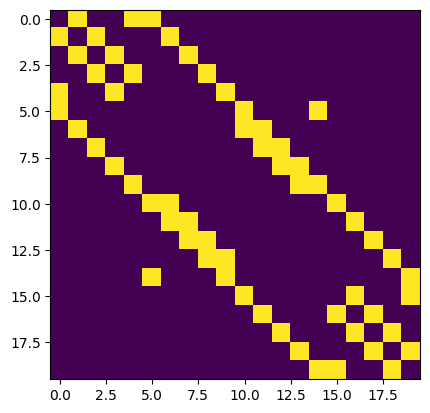

In [7]:
import sys
sys.path.append('d:/code/pywfn')
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pywfn.base import Mol
from pywfn.reader import LogReader,GjfReader
from pywfn.bondprop import order
path="D:\gfile\pywfn\C20.log"
mol=Mol(LogReader(path))

# path="D:\gfile\pywfn\dingerxi.gjf"
# mol=Mol(GjfReader(path))


atms=mol.heavyAtoms
natm=len(atms)
BM=np.zeros(shape=(natm,natm)) # 键连矩阵
DM=np.zeros_like(BM) # 键长矩阵
for i,j in product(range(natm),range(natm)):
    a1,a2=atms[i],atms[j]
    if a1>=a2:continue
    bond=mol.atom(a1).coord-mol.atom(a2).coord
    dist=np.linalg.norm(bond)
    DM[i,j]=dist
    DM[j,i]=dist
    if dist>1.7*1.889:continue
    BM[i,j]=1.0
    BM[j,i]=1.0
# 2.求解
E,C=np.linalg.eig(BM) # 矩阵对角化
print(E)
# e,C=np.linalg.eigh(BM) # 矩阵对角化
nele=int(len(atms)-mol.charge) #电子数量
idxs=np.argsort(E)[::-1] # 占据轨道
# idxs=np.arange(20)
Ct=C[:,idxs] # 每一列对应一个特征向量
Et=E[idxs] # 每一列对应一个特征值
# np.savetxt('C20.txt',C.round(4))
with open('C20.txt','w') as f:
    f.write(''.join([f'{v:>10.4f}' for v in Et])+'\n')
    f.write('-'*(Ct.shape[0]*10)+'\n')
    for i in range(Ct.shape[0]):
        f.write(''.join([f'{v:>10.4f}' for v in Ct[i,:]])+'\n')
plt.imshow(BM)

In [103]:
D=np.diag(Et)
print(np.allclose(BM,Ct@D@np.linalg.inv(Ct)))
delta=BM-Ct@D@np.linalg.inv(Ct)
delta.min(),delta.max()

True


(np.float64(-1.3322676295501878e-15), np.float64(2.06635732779005e-15))

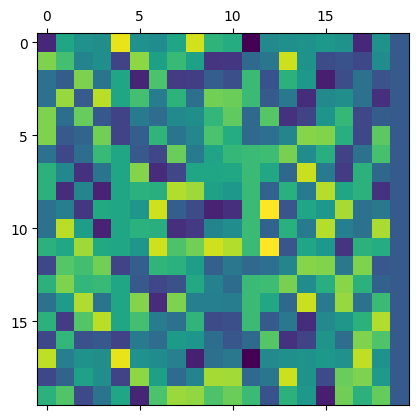

In [56]:
e,C=np.linalg.eig(BM)
idxs=np.argsort(e)
C=C[:,idxs].copy()
plt.matshow(C)

In [45]:
BM@C

array([[ 0.866 ,  0.0002,  0.0034,  0.0004, -0.8944, -0.0088,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    , -0.495 ,  0.0005,  0.0669,
         0.    , -0.0216,  0.8655, -0.    , -0.0288, -0.6708],
       [-0.6434, -0.2338, -0.5305, -0.2366,  0.5916,  0.4723,  0.4135,
         0.    ,  0.    , -0.    ,  0.    , -0.1402, -0.167 ,  0.2006,
         0.4018, -0.0276,  0.6456, -0.5772, -0.0084, -0.6708],
       [ 0.287 ,  0.7185,  0.389 ,  0.5152, -0.1418, -0.7168,  0.0266,
         0.    ,  0.    ,  0.    ,  0.    ,  0.2016, -0.2954,  0.1485,
         0.0595, -0.3107,  0.3056, -0.634 ,  0.5046, -0.6708],
       [ 0.291 , -0.5884, -0.5649,  0.0654, -0.157 ,  0.8096, -0.3401,
         0.    ,  0.    ,  0.    , -0.    ,  0.2099, -0.0685,  0.3151,
        -0.3185,  0.0228,  0.3155, -0.092 ,  0.8013, -0.6708],
       [-0.6459,  0.5739,  0.0591, -0.3444,  0.6016, -0.5563, -0.1   ,
        -0.    ,  0.    , -0.    , -0.    , -0.1345,  0.3567,  0.2158,
        -0.2205, -0.0972,  0.6615,  0.

In [46]:
np.sum(C**2,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [47]:
from pywfn.bondprop import order
order.Calculator(mol).hmo()[0]

array([[ 1.    ,  2.    ,  0.4843],
       [ 1.    ,  5.    ,  0.4783],
       [ 1.    ,  6.    ,  0.5407],
       [ 2.    ,  3.    ,  0.4581],
       [ 2.    ,  7.    ,  0.3689],
       [ 3.    ,  4.    ,  0.6018],
       [ 3.    ,  8.    ,  0.4584],
       [ 4.    ,  5.    ,  0.4361],
       [ 4.    ,  9.    ,  0.4936],
       [ 5.    , 10.    ,  0.5363],
       [ 6.    , 11.    ,  0.4456],
       [ 6.    , 15.    ,  0.6607],
       [ 7.    , 11.    ,  0.5758],
       [ 7.    , 12.    ,  0.2717],
       [ 8.    , 12.    ,  0.5438],
       [ 8.    , 13.    ,  0.6607],
       [ 9.    , 13.    ,  0.4456],
       [ 9.    , 14.    ,  0.5758],
       [10.    , 14.    ,  0.2717],
       [10.    , 15.    ,  0.5438],
       [11.    , 16.    ,  0.4936],
       [12.    , 17.    ,  0.5363],
       [13.    , 18.    ,  0.5407],
       [14.    , 19.    ,  0.3689],
       [15.    , 20.    ,  0.4584],
       [16.    , 17.    ,  0.4361],
       [16.    , 20.    ,  0.6018],
       [17.    , 18.    ,  0

In [48]:
np.linalg.norm(mol.coords,axis=1)

array([3.722 , 3.6491, 3.7212, 3.9141, 3.914 , 3.9138, 3.7208, 3.9137,
       3.9137, 3.9137, 3.9137, 3.9137, 3.9138, 3.7208, 3.9137, 3.9141,
       3.914 , 3.722 , 3.6491, 3.7212])

In [49]:
M=[
    [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
]
M=np.array(M)

In [27]:
import sympy as sp
a,b,c,d,e,f,g,h,i=sp.symbols('a b c d e f g h i')
M=sp.Matrix([
    [a,b,c],
    [d,e,f],
    [g,h,i]
])
M

Matrix([
[a, b, c],
[d, e, f],
[g, h, i]])

In [30]:
sp.Inverse(M)

Matrix([
[a, b, c],
[d, e, f],
[g, h, i]])**(-1)